# Chicken Detection Model
#### Transfer learning MobilenetSSD_V2 - Train last layer on Chicken detections 

Features:
- [x] Annotated Dataset of Chickens from COCO format to Tensorflow Record
- [ ] Transfer learning MobilenetSSD_V2 can detect chickens
- [ ] Convert to coral capable model (Tensorflow Lite and Quantisation)

Based on a [tutorial](https://colab.research.google.com/github/Namburger/edgetpu-ssdlite-mobiledet-retrain/blob/master/ssdlite_mobiledet_transfer_learning_cat_vs_dog.ipynb?pli=1&authuser=2#scrollTo=YetL1g47nyec).

In [1]:
%tensorflow_version 1.x
!pip install tf_slim
!pip show tensorflow

TensorFlow 1.x selected.
     |████████████████████████████████| 358kB 9.3MB/s 
Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.7
Requires: keras-preprocessing, wrapt, astor, google-pasta, opt-einsum, absl-py, tensorflow-estimator, numpy, grpcio, wheel, gast, keras-applications, six, tensorboard, termcolor, protobuf
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
# Install protobuf-compiler and the tensorflow's object detection API.
!apt-get install protobuf-compiler
!git clone https://github.com/tensorflow/models.git

import os
os.environ['PYTHONPATH'] += ':/content/models/research/'
os.environ['PYTHONPATH'] += ':/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/utils/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection'

%cd models/research
# Compile all the protobuf dependencies.
!protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install .
# Run a test to make sure setup is correct.
!python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'models'...
remote: Enumerating objects: 56619, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 56619 (delta 126), reused 104 (delta 3), pack-reused 56385
Receiving objects: 100% (56619/56619), 572.47 MiB | 31.50 MiB/s, done.
Resolving deltas: 100% (39079/39079), done.
/content/models/research
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1647280 sha256=5f654e36de22ea1435abf7521efd96ccf3294414fcaf0dd2a21c6ac642463458
  Stored in directory: /tmp/pip-ephem-wheel-cache-7

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
# !ls /content/gdrive/MyDrive/chickenDetectionDataset/ChickenDetectionDataset
!cp -r /content/gdrive/MyDrive/chickenDetectionDataset/ChickenDetectionDataset /content/dataset

In [37]:
!python3 /content/models/research/object_detection/dataset_tools/create_coco_tf_record.py --logtostderr \
      --train_image_dir="/content/dataset/ChickenDetectionDataset/Train/images" \
      --val_image_dir="/content/dataset/ChickenDetectionDataset/Evaluation/images" \
      --test_image_dir="/content/dataset/ChickenDetectionDataset/Test/images" \
      --train_annotations_file="/content/dataset/ChickenDetectionDataset/Train/annotations/annotations.json" \
      --val_annotations_file="/content/dataset/ChickenDetectionDataset/Evaluation/annotations/annotations.json" \
      --testdev_annotations_file="/content/dataset/ChickenDetectionDataset/Test/annotations/annotations.json" \
      --output_dir="/content/tf_dataset"

I0429 18:03:27.039398 140261084755840 create_coco_tf_record.py:399] Found groundtruth annotations. Building annotations index.
I0429 18:03:27.039691 140261084755840 create_coco_tf_record.py:412] 0 images are missing annotations.
I0429 18:03:27.039977 140261084755840 create_coco_tf_record.py:441] On image 0 of 30
I0429 18:03:27.121057 140261084755840 create_coco_tf_record.py:466] Finished writing, skipped 84 annotations.
I0429 18:03:27.129199 140261084755840 create_coco_tf_record.py:399] Found groundtruth annotations. Building annotations index.
I0429 18:03:27.129435 140261084755840 create_coco_tf_record.py:412] 1 images are missing annotations.
I0429 18:03:27.129536 140261084755840 create_coco_tf_record.py:441] On image 0 of 13
I0429 18:03:27.159198 140261084755840 create_coco_tf_record.py:466] Finished writing, skipped 25 annotations.
I0429 18:03:27.162632 140261084755840 create_coco_tf_record.py:399] Found groundtruth annotations. Building annotations index.
I0429 18:03:27.162812 140

In [17]:
# Now let's download our ssdlite mobiledet pretrained model from tensorflow's model zoo.
!mkdir /content/pretrained_model
%cd /content/pretrained_model
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
!tar xvf ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz

/content/pretrained_model
--2021-04-29 17:07:34--  http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156413934 (149M) [application/x-tar]
Saving to: ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz’

ssdlite_mobiledet_e 100%[===================>] 149.17M   156MB/s    in 1.0s    

2021-04-29 17:07:35 (156 MB/s) - ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz’ saved [156413934/156413934]

ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt-400000.data-00000-of-00001
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt-400000.

In [38]:
# Edit Pipeline config to load in our new tfrecord that we just created and add quantization aware training.
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

# Hack to find out if you have colab pro or not :)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
# You get Tesla T4 with free colab and Tesla P100-PCIe with colab pro.
colab_pro = False if 'T4' in gpu_name else True

pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
config_path = '/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config'
with tf.gfile.GFile(config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/content/tf_dataset/coco_train.record-?????-of-00100']
pipeline.train_input_reader.label_map_path = '/content/dataset/ChickenDetectionDataset/label_map.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/content/tf_dataset/coco_val.record-?????-of-00050']
pipeline.eval_input_reader[0].label_map_path = '/content/dataset/ChickenDetectionDataset/label_map.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/content/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt'
pipeline.train_config.batch_size = 64 if colab_pro else 32 # Smaller batch size on free gpu to avoid OOM Killer
pipeline.train_config.num_steps = 25000 if colab_pro else 10000 # Less steps with free gpu but 10k should be good enough
pipeline.model.ssd.num_classes = 2
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Training
pipeline.graph_rewriter.quantization.delay = 0
pipeline.graph_rewriter.quantization.weight_bits = 8
pipeline.graph_rewriter.quantization.activation_bits = 8

config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
with tf.gfile.Open(config_path, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)

# This is out config after modifying.
!cat /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobiledet_edgetpu"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97
          center: true
          scale: true
          epsilon: 0.001
          train: true
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: false
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.

In [22]:
# Before we start training, let's start tensorboard so we can track the progress.
# More info on tensorflow can be found here: https://www.tensorflow.org/tutorials
%cd /content
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

/content
--2021-04-29 17:17:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.233.212.111, 3.227.65.201, 54.164.22.162, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.233.212.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13828408 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.5MB/s    in 0.8s    

2021-04-29 17:17:30 (17.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13828408/13828408]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [39]:
# Starts tensorboard, so we can monitor the training process.
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format('/content/train')
)
get_ipython().system_raw('./ngrok http 6006 &')
print('Click on link below to track progress:')
import time
time.sleep(1)
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Click on link below to track progress:
http://bdfb27a35feb.ngrok.io


In [45]:
# Let's begin training, expects to take a few hours, time for a good stretch :)
%cd /content/models/research/
!python3 object_detection/model_main.py \
    --logtostderr=true \
    --model_dir=/content/train \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config

/content/models/research
W0429 18:12:58.709442 140624683714432 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0429 18:12:58.709725 140624683714432 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0429 18:12:58.709829 140624683714432 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0429 18:12:58.709933 140624683714432 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0429 18:12:58.710042 140624683714432 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0429 18:12:58.710183 140624683714432 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: u

In [46]:
# Make inference graph.
!python3 /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
    --output_directory=/content/inference_graph \
    --trained_checkpoint_prefix=/content/train/model.ckpt-0 # Make sure to change this checkpoint to the corresponding num step you set from above.

Instructions for updating:
Please use `layer.__call__` method instead.
W0429 18:15:57.411502 140186002372480 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 18:16:00.314392 140186002372480 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 18:16:00.423742 140186002372480 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 18:16:00.532744 140186002372480 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [33]:
# Let's download some test data from flickr.
!mkdir /content/test
!cd /content/test
!wget https://live.staticflickr.com/4147/5410980795_0979b77500_o_d.jpg -O /content/test/image1.jpg
!wget https://live.staticflickr.com/4090/5146370020_a120afafd3_b_d.jpg -O /content/test/image2.jpg
!wget https://live.staticflickr.com/5609/15343318109_10426d3aa3_b_d.jpg -O /content/test/image3.jpg
!wget https://live.staticflickr.com/7147/6670085437_c93b69700c_b_d.jpg -O /content/test/image4.jpg
!wget https://live.staticflickr.com/8682/28214087384_4c7711584d_c_d.jpg -O /content/test/image5.jpg

--2021-04-29 17:40:21--  https://live.staticflickr.com/4147/5410980795_0979b77500_o_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:4200:0:5a51:64c9:c681, 2600:9000:20be:3a00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385930 (377K) [image/jpeg]
Saving to: ‘/content/test/image1.jpg’

/content/test/image 100%[===================>] 376.88K  --.-KB/s    in 0.1s    

2021-04-29 17:40:21 (3.47 MB/s) - ‘/content/test/image1.jpg’ saved [385930/385930]

--2021-04-29 17:40:22--  https://live.staticflickr.com/4090/5146370020_a120afafd3_b_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:4200:0:5a51:64c9:c681, 2600:9000:20be:3a00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 

Evaluating: /content/test/image1.jpg
Evaluating: /content/test/image2.jpg
Evaluating: /content/test/image3.jpg
Evaluating: /content/test/image4.jpg
Evaluating: /content/test/image5.jpg


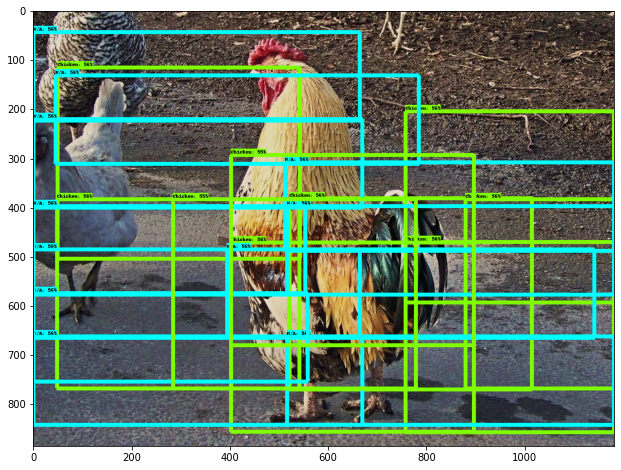

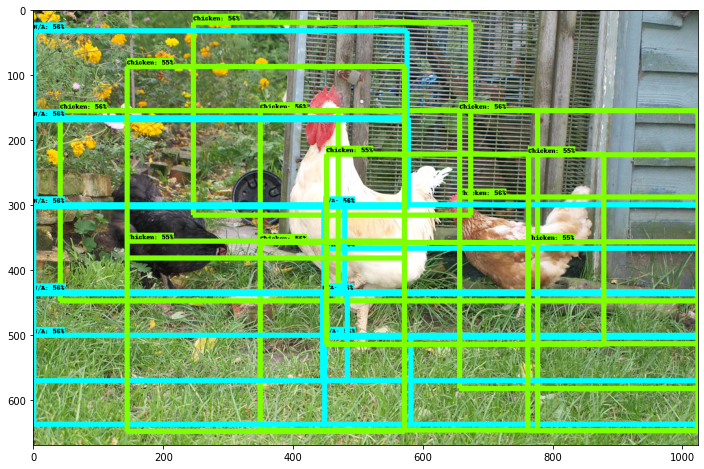

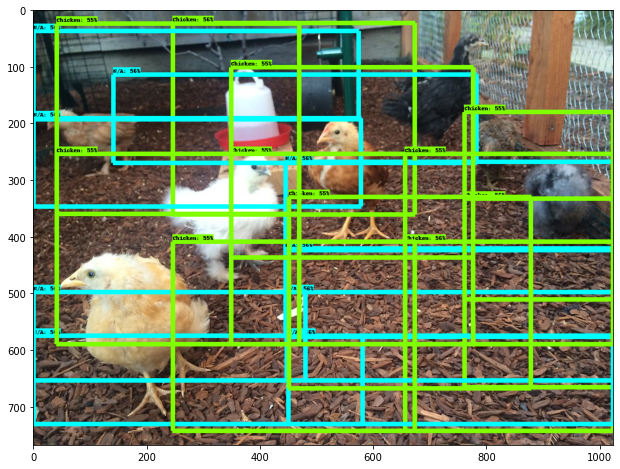

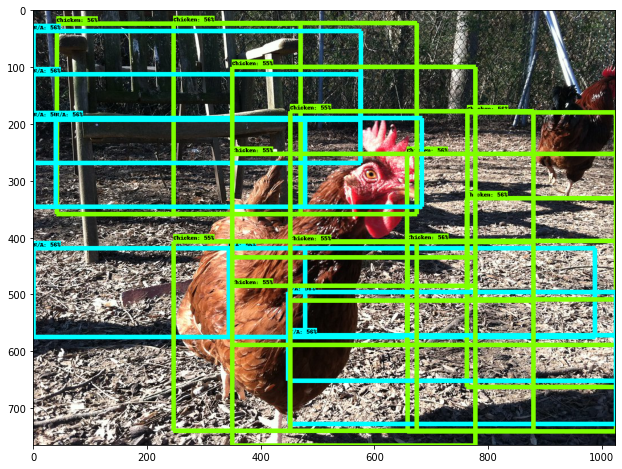

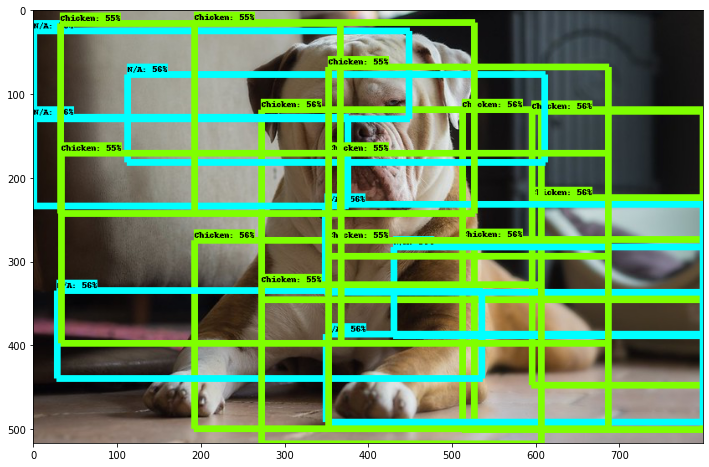

In [47]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('/content/inference_graph/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels/content/dataset/ChickenDetectionDataset/label_map.pbtxt
label_map = label_map_util.load_labelmap('/content/dataset/ChickenDetectionDataset/label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('/content/test', 'image{}.jpg'.format(i)) for i in range(1, 6)]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

In [ ]:
# Now we export this model to tflite_graph format.
%cd /content/models/research
!mkdir /content/output_model
!python3 object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
  --trained_checkpoint_prefix=/content/train/model.ckpt-25000 \
  --output_directory=/content/output_model \
  --add_postprocessing_op=true
# Make sure to change the model-ckpt-# to match the checkpoint number you used.

In [ ]:
# Now we can convert this custom trained model to a CPU tflite model
!tflite_convert \
  --output_file="/content/output_model/ssdlite_mobiledet_dog_vs_cat.tflite" \
  --graph_def_file="/content/output_model/tflite_graph.pb" \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays="normalized_input_image_tensor" \
  --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,320,320,3 \
  --allow_custom_ops

In [ ]:
# Install tflite_runtime package to evaluate the model.
!pip3 install https://github.com/google-coral/pycoral/releases/download/release-frogfish/tflite_runtime-2.5.0-cp36-cp36m-linux_x86_64.whl  

In [ ]:
# Now we do evaluation on the tflite model.
import os
import numpy as np
from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = Interpreter('/content/output_model/ssdlite_mobiledet_dog_vs_cat.tflite')
# This exact code can be used to run inference on the edgetpu by simply creating 
# the instantialize the interpreter with libedgetpu delegates:
# interpreter = Interpreter(args.model, experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

test_image_paths = [os.path.join('/content/test', 'image{}.jpg'.format(i)) for i in range(1, 6)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.asarray(resized_image)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # Draw results on image
  colors = {0:(128, 255, 102), 1:(102, 255, 255)}
  labels = {0:'abyssian cat', 1:'american bulldog'}
  for i in range(len(boxes)):
    if scores[i] > .7:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

In [ ]:
# Install the edgetpu compiler.
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

In [ ]:
# Compile our model and make a tarball of the finished trained model.
%cd /content/output_model
!edgetpu_compiler -s ssdlite_mobiledet_dog_vs_cat.tflite
%cd /content/
# Copy the checkpoints, inference graph, pipeline config, and the tflite models.
!cp -r /content/train/model.ckpt-50000* /content/output_model
!cp -r /content/inference_graph/* /content/output_model
!tar cvf ssdlite_mobiledet_dog_vs_cat.tar.gz output_model

In [ ]:
# Download model and you're done!
from google.colab import files
files.download('/content/ssdlite_mobiledet_dog_vs_cat.tar.gz')